In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import fftpack
from scipy.interpolate import griddata
import copy


---
# VIDEO: Upsampling
---


When you have a low sampling rate and you want a higher sampling rate.

We use an interpolation function (like spline) to estimate points between the existing points.

Ideally we want the resulting fft spectrum to look similar than the original

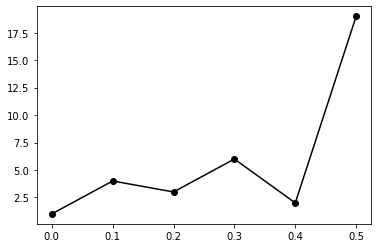

In [23]:
## low-sampling-rate data to upsample

# in Hz
srate = 10

# just some numbers...
data  = np.array( [1, 4, 3, 6, 2, 19] )

# other parameters
npnts = len(data)
time  = np.arange(0,npnts)/srate

# plot the original signal
plt.plot(time,data,'ko-')
plt.show()

In [24]:
## option 1: upsample by a factor

upsampleFactor = 4
newNpnts = npnts*upsampleFactor

# the new_sr is also sr*factor

# new time vector after upsampling
newTime = np.arange(0,newNpnts)/(upsampleFactor*srate)

In [25]:
## option 2: upsample to desired frequency, then cut off points if necessary

# in Hz
newSrate = 37
 
# need to round in case it's not exact
newNpnts = np.round( npnts * (newSrate/srate) )
 
# new time vector after upsampling
newTime = np.arange(0,newNpnts) / newSrate


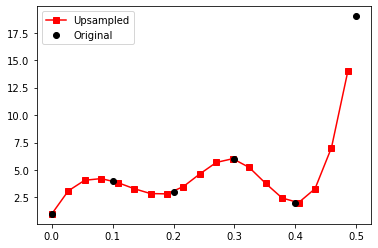

In [26]:
## continue on to interpolation

# cut out extra time points
newTime = newTime[newTime<time[-1]]

# the new sampling rate actually implemented
newSrateActual = 1/np.mean(np.diff(newTime))



# interpolate using griddata
updataI = griddata(time, data, newTime, method='cubic')

# plot the upsampled signal
plt.plot(newTime,updataI,'rs-',label='Upsampled')
plt.plot(time,data,'ko',label='Original')
plt.legend()
plt.show()

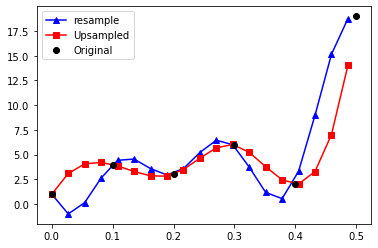

In [27]:
## using Python's resample function

# new sampling rate in Hz
newSrate = 37


# use resample function
newNpnts = int( len(data)*newSrate/srate )
updataR = signal.resample(data,newNpnts)

# the new time vector
newTimeR = np.arange(0,newNpnts)/newSrate


# cut out extra time points
updataR  = updataR[newTimeR<time[-1]]
newTimeR = newTimeR[newTimeR<time[-1]]


# and plot it
plt.plot(newTimeR,updataR,'b^-',label='resample')
plt.plot(newTime,updataI,'rs-',label='Upsampled')
plt.plot(time,data,'ko',label='Original')
plt.legend()
plt.show()


---
# VIDEO: Downsampling
---

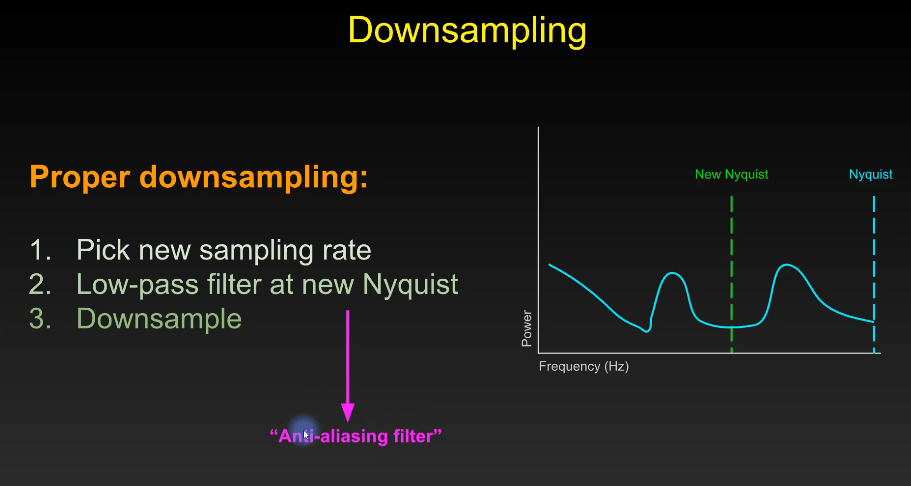

The Spectrum filter ensures that you keep similar spectrums.
In the example below the peak at 15hz is removed with good downsampling but just pushed to 10hz without the filter step.


If you want to downsample from 100hz to 80Hz there is no integer to tell you take every other int points. So in that case the signal is first upsampled then downsampled.!!!!!

So first you upsample by 4 to 400Hz then you downsample by factor 5 to 80Hz

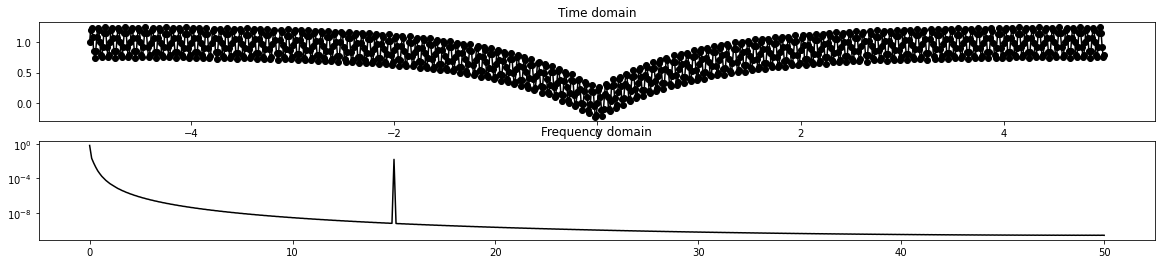

In [43]:
## Laplace distribution

# parameters
srate  = 100
tv     = np.arange(-5,5,1/srate)
npnts  = len(tv)

# signal components
laplace  = 1-np.exp(-np.abs(tv))
fastsine = .25*np.sin(2*np.pi*tv*15) # frequency is 15hz

# combine into one signal (no noise)
signal1 = laplace + fastsine

# power spectrum (O = original)
hzO = np.linspace(0,srate/2,int(np.floor(npnts/2)+1))
signalO_pow = np.abs(scipy.fftpack.fft(signal1)/npnts)**2
signalO_pow = signalO_pow[:len(hzO)]


# time domain signal
plt.figure(figsize=(20,4))
plt.subplot(211)
plt.plot(tv,signal1,'ko-')
plt.title('Time domain')
## optional manual zoom:
#plt.xlim([0,1])


# show power spectrum
plt.subplot(212)
plt.plot(hzO,signalO_pow,'k-')
plt.yscale('log')
plt.title('Frequency domain')
plt.show()


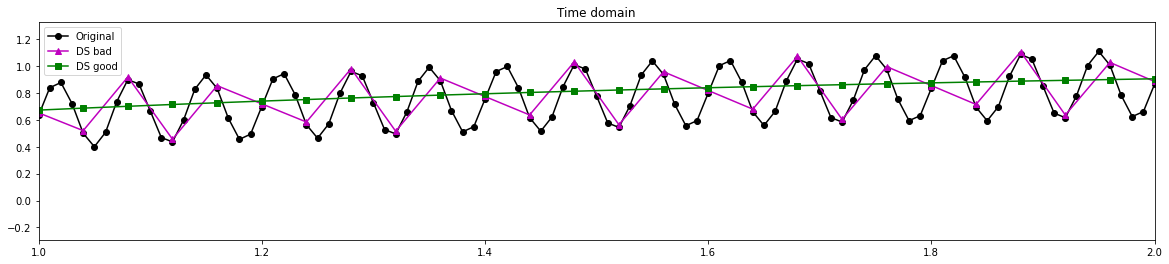

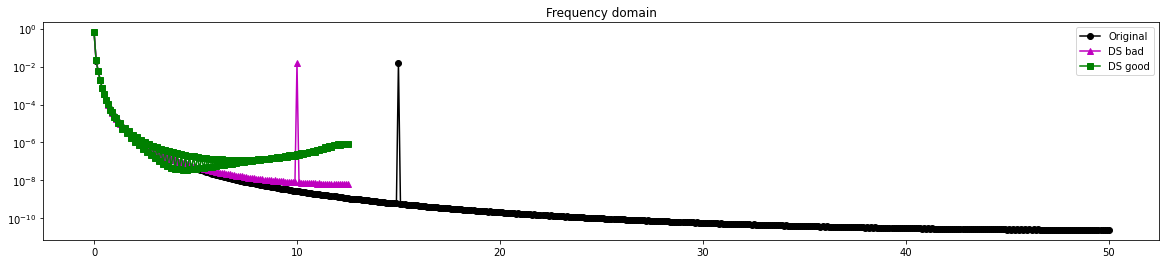

In [44]:
## downsample by a factor

dnsampleFactor = 4
newSrate = srate/dnsampleFactor

# new time vector after upsampling
newTv = np.arange(-5,5,1/newSrate)
newPnts = len(newTv)



### downsample WITHOUT low-pass filtering (bad idea!!)
## Just take one every 4 points without the fft filter.
signal_dsB = signal1[:-1:dnsampleFactor]

# power spectrum (B = bad)
hz_ds = np.linspace(0,newSrate/2,int(np.floor(newPnts/2)+1))
signal_dsB_pow = np.abs(scipy.fftpack.fft(signal_dsB)/newPnts)**2
signal_dsB_pow = signal_dsB_pow[:len(hz_ds)]



### low-pass filter at new Nyquist frequency! (good idea!!)
fkern = signal.firwin(int(14*newSrate/2),newSrate/2,fs=srate,pass_zero=True)
fsignal = signal.filtfilt(fkern,1,signal1)

# now downsample
signal_dsG = fsignal[:-1:dnsampleFactor]

# power spectrum (G = good)
signal_dsG_pow = np.abs(scipy.fftpack.fft(signal_dsG)/newPnts)**2
signal_dsG_pow = signal_dsG_pow[:len(hz_ds)]

fsignal_pow = np.abs(scipy.fftpack.fft(fsignal)/npnts)**2
fsignal_pow = fsignal_pow[:len(hz_ds)]



# plot in the time domain
plt.figure(figsize=(20,4))
plt.plot(tv,signal1,'ko-',label='Original')
plt.plot(newTv,.02+signal_dsB,'m^-',label='DS bad')
plt.plot(newTv,.04+signal_dsG,'gs-',label='DS good')
plt.legend()
## optional change in xlimit to zoom in
plt.xlim([1,2])
plt.title('Time domain')
plt.show()

# plot in the frequency domain
plt.figure(figsize=(20,4))
plt.plot(hzO,signalO_pow,'ko-',label='Original')
plt.plot(hz_ds,signal_dsB_pow,'m^-',label='DS bad')
plt.plot(hz_ds,signal_dsG_pow,'gs-',label='DS good')
plt.legend()
plt.title('Frequency domain')
plt.yscale('log')
plt.show()


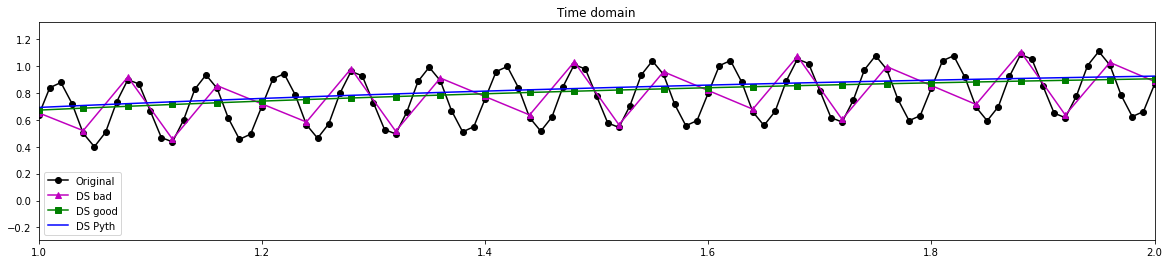

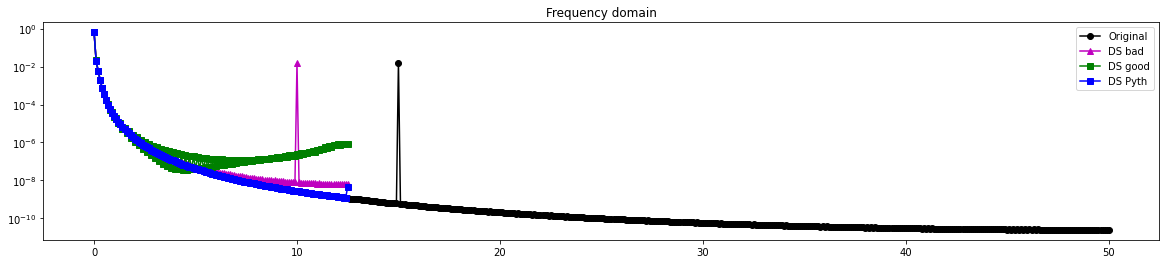

In [47]:
## using Python's resample function

# use resample function
signal_dsP = signal.resample(signal1,newPnts)


# power spectrum (P=Python)
signal_dsP_pow = np.abs(scipy.fftpack.fft(signal_dsP)/newPnts)**2
signal_dsP_pow = signal_dsP_pow[:len(hz_ds)]

plt.figure(figsize=(20,4))
# plot in the time domain
plt.plot(tv,signal1,'ko-',label='Original')
plt.plot(newTv,.02+signal_dsB,'m^-',label='DS bad')
plt.plot(newTv,.04+signal_dsG,'gs-',label='DS good')
plt.plot(newTv,.06+signal_dsP,'b-',label='DS Pyth')
plt.legend()
## optional change in xlimit to zoom in
plt.xlim([1,2])
plt.title('Time domain')
plt.show()


plt.figure(figsize=(20,4))
# frequency domain
plt.plot(hzO,signalO_pow,'ko-',label='Original')
plt.plot(hz_ds,signal_dsB_pow,'m^-',label='DS bad')
plt.plot(hz_ds,signal_dsG_pow,'gs-',label='DS good')
plt.plot(hz_ds,signal_dsP_pow,'bs-',label='DS Pyth')
plt.legend()
plt.title('Frequency domain')
plt.yscale('log')
plt.show()




---
# VIDEO: Strategies for multirate signals
---

When multiple signals are acquire from the same system at different sr. The strategy to have is to upsample all channels to the channel with the highest sr. That way you don't loose points and information.

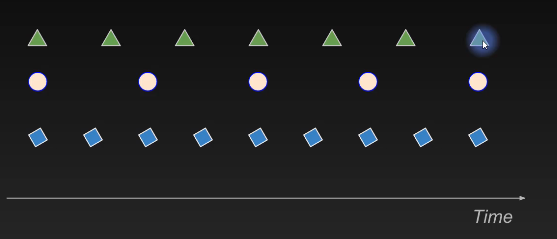

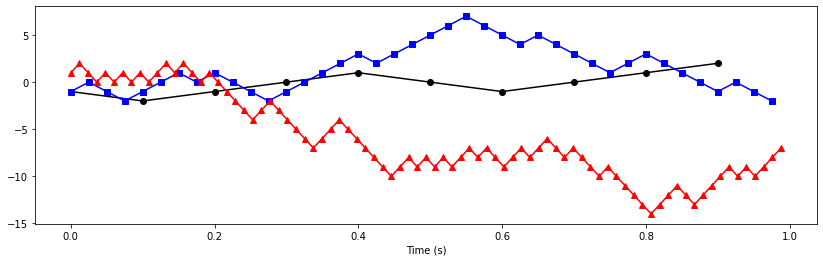

In [50]:
## create multichannel signal with multiple sampling rates

# initialize signals, time vectors, and sampling rates

# sampling rates in Hz
fs = [10,40,83]
timez = np.zeros([3],dtype=object)
signals = np.zeros([3],dtype=object)



# create signals
for si in range(0,3):
    
    # create signal
    signals[si] = np.cumsum( np.sign(np.random.randn(fs[si])) )
    
    # create time vector
    timez[si] = np.arange(0,fs[si])/fs[si]



# # plot all signals
color = 'kbr'
shape = 'os^'
plt.figure(figsize=(14,4))
for si in range(0,3):
    plt.plot(timez[si],signals[si],color[si]+shape[si]+'-')

plt.xlabel('Time (s)')
plt.show()

In [52]:
newNpnts

83.0

In [55]:
len(signals[2])

83

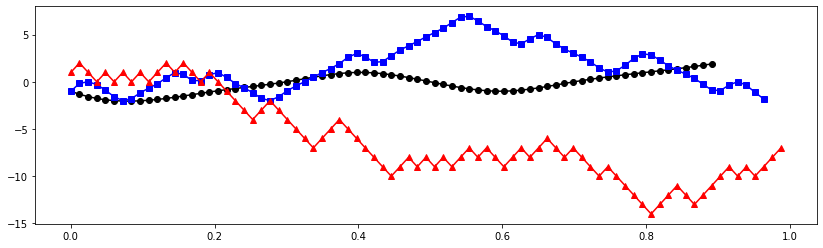

In [51]:
## upsample to fastest frequency

# in Hz
newSrate = np.max(fs)
whichIsFastest = np.argmax(fs)


# need to round in case it's not exact
newNpnts = np.round( len(signals[whichIsFastest]) * (newSrate/fs[whichIsFastest]) )

# new time vector after upsampling
newTime = np.arange(0,newNpnts) / newSrate


# ## continue on to interpolation
# # initialize (as matrix!)
newsignals = np.zeros( (len(fs),len(newTime)) )

for si in range(0,len(fs)):
    
    # interpolate using griddata
    newsignals[si,:] = griddata(timez[si], signals[si], newTime, method='cubic')
    

plt.figure(figsize=(14,4))
### plot for comparison
for si in range(0,3):
    plt.plot(newTime,newsignals[si,:],color[si]+shape[si]+'-')

plt.show()


---
# VIDEO: Interpolating
---

Interpolation is trying to guess datapoints between existing datapoints:

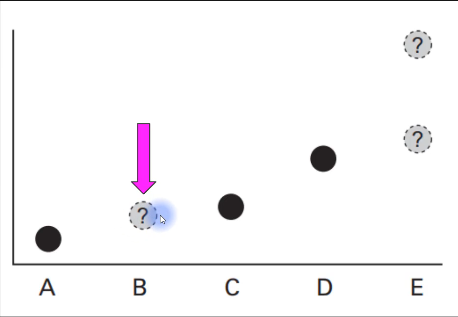

This is the same thing as upsampling.

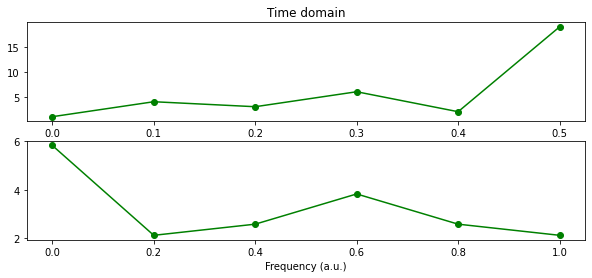

In [7]:
## low-sampling-rate data to upsample

# in Hz
srate = 10

# just some numbers...
data  = np.array( [1, 4, 3, 6, 2, 19] )

# other parameters
npnts = len(data)
time  = np.arange(0,npnts)/srate

plt.figure(figsize=(10,4))
# plot the original data
plt.subplot(211)
plt.plot(time,data,'go-')
plt.title('Time domain')

# amplitude spectrum
plt.subplot(212)
plt.plot(np.linspace(0,1,npnts),np.abs(scipy.fftpack.fft(data/np.array(npnts))),'go-')
plt.xlabel('Frequency (a.u.)')

plt.show()

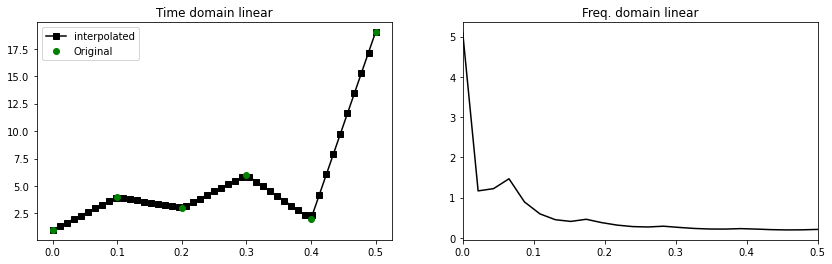

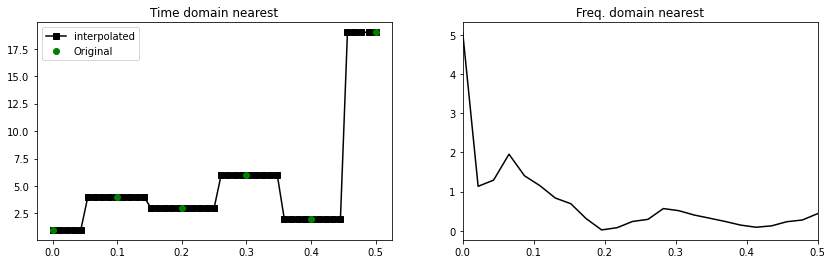

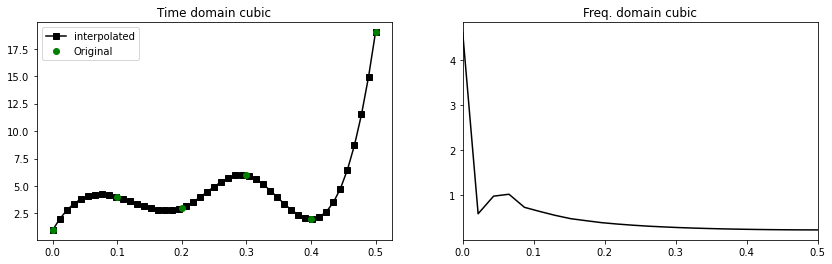

In [11]:
## interpolation

# new time vector for interpolation
N = 47
newTime = np.linspace(time[0],time[-1],N)

# different interpolation options
interpOptions = ['linear','nearest','cubic']


for methodi in range(0,len(interpOptions)):
    
    # interpolate using griddata
    newdata = griddata(time, data, newTime, method=interpOptions[methodi])
    plt.figure(figsize=(14,4))
    # plotting
    plt.subplot(121)
    plt.plot(newTime,newdata,'ks-',label='interpolated')
    plt.plot(time,data,'go',label='Original')
    plt.title('Time domain '+interpOptions[methodi])
    plt.legend()
    
    plt.subplot(122)
    plt.plot(np.linspace(0,1,N),np.abs(scipy.fftpack.fft(newdata/N)),'k')
    plt.xlim([0,.5])
    plt.title('Freq. domain '+interpOptions[methodi])
    plt.show()
    


---
# VIDEO: Resample irregularly sampled data
---

Irregular mean with non constant sampling rate, like in dynamic sampling in CM.

The nswer is to just interpolate as before :)

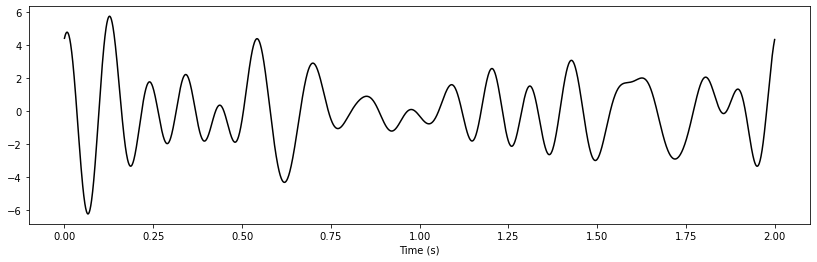

In [14]:
# simulation parameters
srate    = 1324    # Hz
peakfreq =    7    # Hz
fwhm     =    5    # Hz
npnts    = srate*2 # time points
timevec  = np.arange(0,npnts)/srate # seconds

# frequencies
hz = np.linspace(0,srate,npnts)
s  = fwhm*(2*np.pi-1)/(4*np.pi) # normalized width
x  = hz-peakfreq                # shifted frequencies
fg = np.exp(-.5*(x/s)**2)       # gaussian


# Fourier coefficients of random spectrum
fc = np.random.rand(npnts) * np.exp(1j*2*np.pi*np.random.rand(npnts))

# taper with Gaussian
fc = fc * fg

# go back to time domain to get signal
signal1 = 2*np.real( scipy.fftpack.ifft(fc) )*npnts

plt.figure(figsize=(14,4))
### plot 
plt.plot(timevec,signal1,'k')
plt.xlabel('Time (s)')
plt.show()

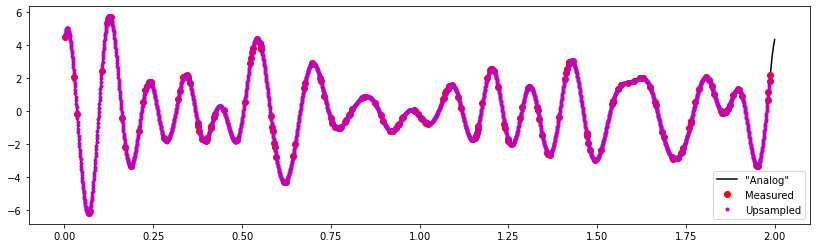

In [15]:
## now randomly sample from this "continuous" time series

# initialize to empty
sampSig = []


# random sampling intervals
sampintervals = np.append(1,np.cumsum(np.ceil( np.exp(4*np.random.rand(npnts)))))
sampintervals = sampintervals[sampintervals<np.array(npnts)]  # remove points beyond the data

# loop through sampling points and "measure" data
for i in range(0,len(sampintervals)):
    
    # "real world" measurement
    nextdat = signal1[ int(sampintervals[i]) ] , timevec[ int(sampintervals[i]) ]
    
    # put in data matrix
    sampSig.append(nextdat)

# needs to be numpy array
sampSig = np.array(sampSig)

## upsample to original sampling rate
# interpolate using griddata
newsignal = griddata(sampSig[:,1], sampSig[:,0], timevec, method='cubic')

plt.figure(figsize=(14,4))
### and plot everything
plt.plot(timevec,signal1,'k',label='"Analog"')
plt.plot(sampSig[:,1],sampSig[:,0],'ro',label='Measured')
plt.plot(timevec,newsignal,'m.',label='Upsampled')
plt.legend()

## optional zoom
#plt.xlim([1,1.1])

plt.show()


---
# VIDEO: Extrapolating
---

Guessing what is outside the datapoints:

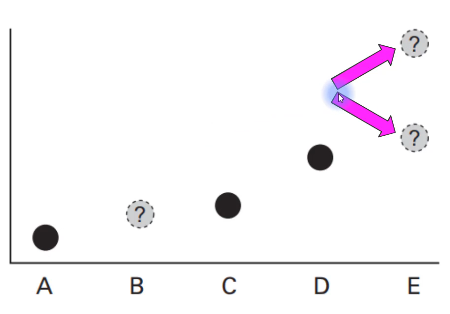

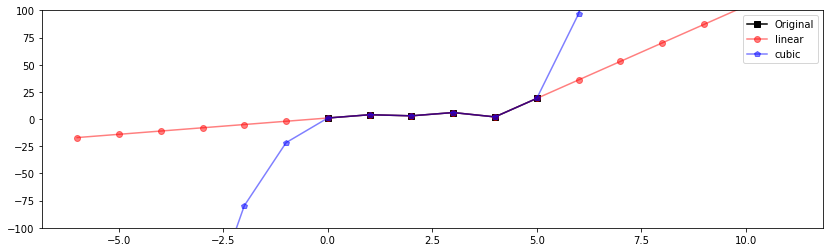

In [17]:
# get the landscape
signal1 = np.array( [1, 4, 3, 6, 2, 19] )
timevec = np.arange(0,len(signal1))


## two methods of extrapolation

times2extrap = np.arange(-len(signal1),2*len(signal1))


# get extrapolation classes
Flin = scipy.interpolate.interp1d(timevec,signal1,kind='linear',fill_value='extrapolate')
Fcub = scipy.interpolate.interp1d(timevec,signal1,kind='cubic',fill_value='extrapolate') # cubic is also called spline

# now extra/interpolate
extrapLin = Flin(times2extrap)
extrapCub = Fcub(times2extrap)

plt.figure(figsize=(14,4))
# # plot them
plt.plot(timevec,signal1,'ks-',label='Original')
plt.plot(times2extrap,extrapLin,'ro-',alpha=0.5, label='linear')
plt.plot(times2extrap,extrapCub,'bp-',alpha=0.5, label='cubic')
plt.legend()

## optional zoom
plt.ylim([-100,100])

plt.show()


---
# VIDEO: Spectral interpolation
---

Usefull when missing a large chunk of time from a signal (expl a sensor died for a minute)

To solve it you look at a window of data before the missing chunk and after the missing chunk.
You fft these 2 windows, then you average the 2 spectrum together, and you inverse fft them.
The resulting signal in fitted into the missing chunk

A final trick is to add a linear trend to this resulted signal to make it link better to the edges.

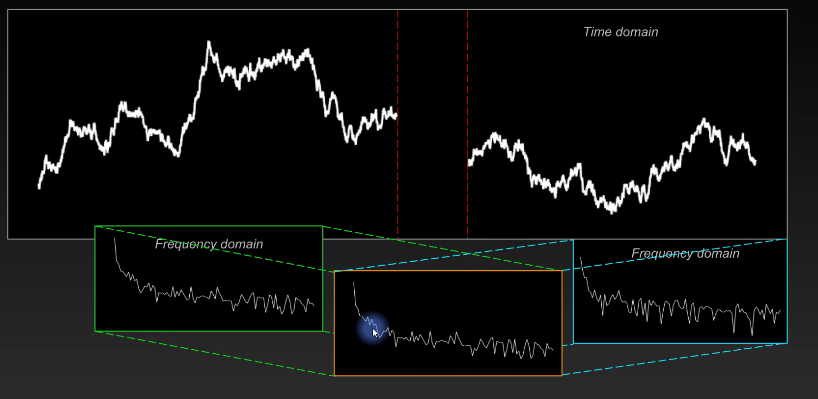

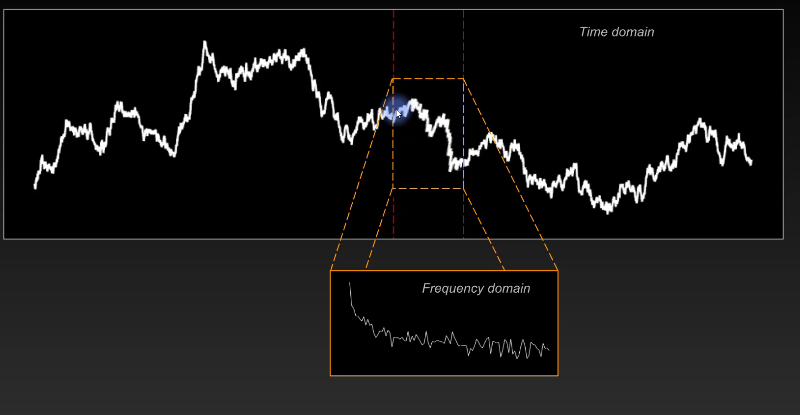

window size [1500]


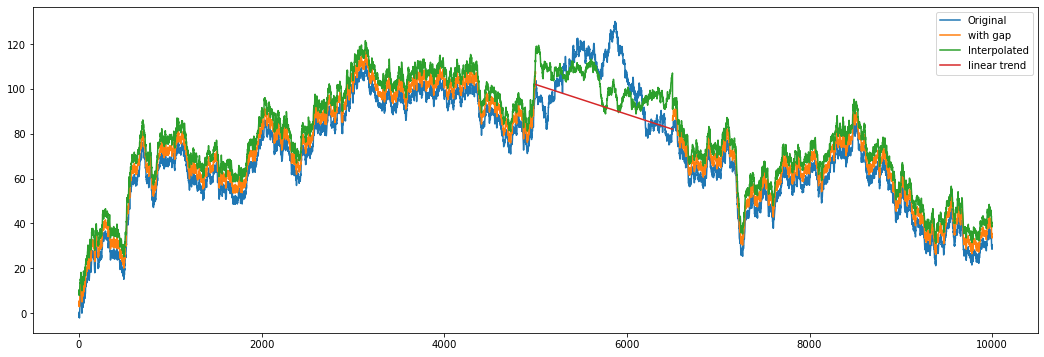

In [28]:
# number of points in signal
n = 10000

# create signal
origsig = np.cumsum( np.random.randn(n) )
signal1 = copy.deepcopy(origsig)


# remove a specified window
boundaryPnts = [ 5000, 6500 ]
signal1[range(boundaryPnts[0],boundaryPnts[1])] = np.nan


# FFTs of pre- and post-window data
print(f"window size {np.diff(boundaryPnts)}")
fftPre = scipy.fftpack.fft(signal1[ range(boundaryPnts[0]-int(np.diff(boundaryPnts)), boundaryPnts[0])] )
fftPst = scipy.fftpack.fft(signal1[ range(boundaryPnts[1]+1, boundaryPnts[1]+int(np.diff(boundaryPnts)+1))] )


# interpolated signal is a combination of mixed FFTs and straight line
mixeddata = scipy.signal.detrend( np.real(scipy.fftpack.ifft( ( fftPre+fftPst )/2 )))
linedata  = np.linspace(0,1,int(np.diff(boundaryPnts))) * (signal1[boundaryPnts[1]+1]-signal1[boundaryPnts[0]-1]) + signal1[boundaryPnts[0]-1]

# sum together for final result
linterp = mixeddata + linedata

# put the interpolated piece into the signal
filtsig = copy.deepcopy( signal1 )
filtsig[ range(boundaryPnts[0],boundaryPnts[1]) ] = linterp


plt.figure(figsize=(18,6))
plt.plot(np.arange(0,n),origsig,label='Original')
plt.plot(np.arange(0,n),signal1+5,label='with gap') # +5 is just an offset to see better
plt.plot(np.arange(0,n),filtsig+10,label='Interpolated')
plt.plot(range(boundaryPnts[0],boundaryPnts[1]), linedata, label='linear trend')
plt.legend()

## optional zoom
#plt.xlim([boundaryPnts[0]-150, boundaryPnts[1]+150])

plt.show()

In [22]:
linedata

array([-42.16501969, -42.20135772, -42.23769576, ..., -96.56305988,
       -96.59939792, -96.63573595])

In [ ]:
signal1[boundaryPnts[1]+1]-signal1[boundaryPnts[0]-1]

-54.470716264884295


---
# VIDEO: Dynamic time warping
---

Method to match 2 signals by non linear time warping.

It works by creating a distance matrix: distance between 2 points for all possible pair of time points.
Then you find a path in this matrix that minimize distances

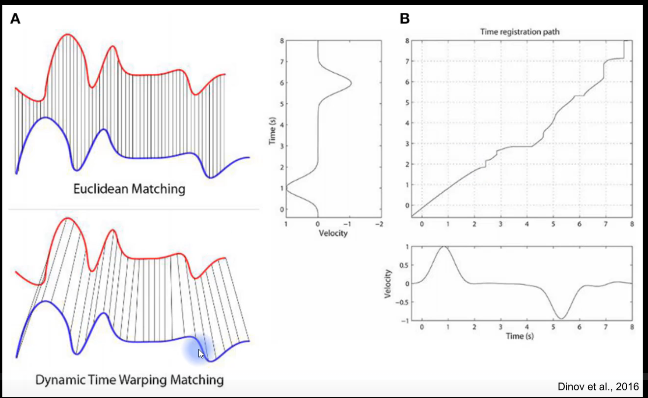

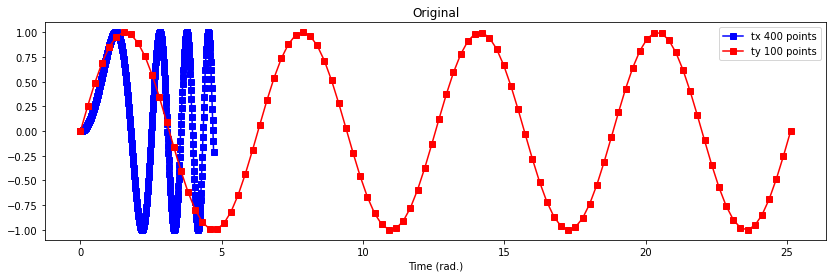

In [63]:
## create signals

# different time vectors
tx = np.linspace(0,1.5*np.pi,400)
ty = np.linspace(0,8*np.pi,100)

# different signals
x = np.sin(tx**2) # chirp
y = np.sin(ty);# sine wave

plt.figure(figsize=(14,4))
# show them
plt.plot(tx,x,'bs-', label='tx 400 points')
plt.plot(ty,y,'rs-', label='ty 100 points')
plt.xlabel('Time (rad.)')
plt.title('Original')
plt.legend()
plt.show()

C:\Users\fabrice.lacout\AppData\Local\Temp\ipykernel_18484\1690676134.py:4: RuntimeWarning: invalid value encountered in true_divide
  dm = np.zeros((len(x),len(y)))/0


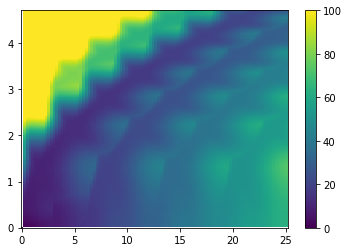

In [66]:
## distance matrix

# initialize distance matrix (dm) and set first element to zero
dm = np.zeros((len(x),len(y)))/0
dm[0,0] = 0

# distance matrix
for xi in range(1,len(x)):
    for yi in range(1,len(y)):
        cost = np.abs(x[xi]-y[yi])
        # the min ensure the indixes are increasing in order during the path search
        dm[xi,yi] = cost + np.nanmin([ dm[xi-1,yi], dm[xi,yi-1], dm[xi-1,yi-1] ])
        

pc = plt.pcolormesh(ty,tx,dm,vmin=0,vmax=100)
plt.colorbar(pc)
plt.show()

In [67]:
dm.shape

(400, 100)

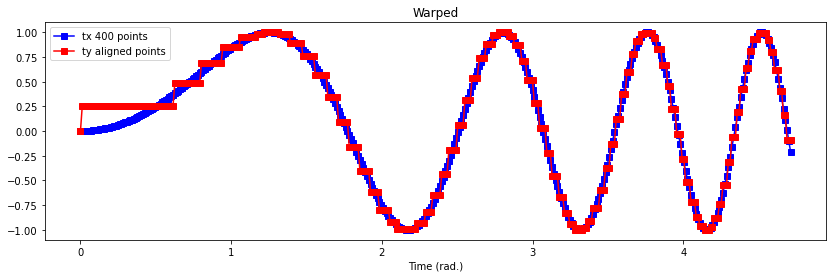

In [68]:
# Align Red against Blue
# find minimum for each y
minpath = np.zeros((2,len(x)),'int')

for xi in range(0,len(x)):
    minpath[0,xi] = np.nanmin(dm[xi,:])
    minpath[1,xi] = np.nanargmin(dm[xi,:]) #indexes

plt.figure(figsize=(14,4))
plt.plot(tx,x,'bs-', label='tx 400 points')
plt.plot(tx,y[minpath[1,:]],'rs-',  label='ty aligned points')
plt.xlabel('Time (rad.)')
plt.title('Warped')
plt.legend()
plt.show()

In [60]:
minpath.shape

(2, 400)

In [61]:
minpath[1,:]

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  7,  7,  7,
        7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23,
       23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27,
       27, 27, 27, 28, 28

In [62]:
dm[53,:]

array([        nan,  7.71897927,  7.69257907,  7.89721462,  8.2882864 ,
        8.81094694,  9.40359317, 10.00052315, 10.51464446, 10.88852157,
       11.07370898, 11.1135613 , 11.40037771, 11.94025157, 12.68888531,
       13.40210034, 14.29291823, 15.31032856, 16.39520605, 17.48410056,
       18.51330446, 19.42293646, 20.16078011, 20.68563106, 20.96993835,
       20.51827345, 17.77182005, 17.86074938, 18.17078309, 18.65446827,
       19.24440737, 19.86240904, 20.44437873, 20.92853167, 21.25935338,
       21.39115831, 21.49129822, 21.84144275, 22.44362574, 23.28372473,
       24.33236619, 25.54680851, 26.87368179, 28.2493485 , 29.60245198,
       30.86464117, 31.91950948, 32.78125667, 33.41708423, 33.7987399 ,
       33.9157287 , 33.17932812, 33.38015358, 33.77442758, 34.30218711,
       34.9051224 , 35.52010472, 36.08323307, 36.53393047, 36.818827  ,
       36.89518106, 37.05674299, 37.47034339, 38.13394841, 39.02949826,
       40.11598298, 41.31430744, 42.60663795, 43.92238836, 45.19